# Load package

In [1]:
import pandas as pd
import numpy as np
import datetime
import sqlite3
import matplotlib.pyplot as plt
%matplotlib inline 
from random import sample

# Load data from database

In [3]:
# path = '../data/'
path = 'data/NYC_2013/'
conn = sqlite3.connect(path + 'trip_data.db')

In [4]:
q_license = """
SELECT distinct(hack_license) as UNIQ_LIC
FROM trip
"""

unique_license = pd.read_sql(q_license, conn)

In [5]:
LIC_SAMPLE_NUM = 5000
sampled_drivers = sample(unique_license.UNIQ_LIC.tolist(), LIC_SAMPLE_NUM)

In [6]:
# find the pickup and dropoff time of next trip
q_sample = """
SELECT *, 
        lag(pickup_datetime, -1, NULL) over (partition by hack_license order by pickup_datetime) as pickup_datetime_next,
        lag(dropoff_datetime, -1, NULL) over (partition by hack_license order by pickup_datetime) as dropoff_datetime_next
    FROM trip
    WHERE hack_license in {0}
ORDER BY hack_license ASC, pickup_datetime ASC, dropoff_datetime ASC
"""

sampled_trip = pd.read_sql(q_sample.format(tuple(sampled_drivers)), conn)

In [7]:
conn.close()

In [8]:
sampled_trip.head()

,medallion,hack_license,vendor_id,rate_code,pickup_datetime,dropoff_datetime,passenger_count,trip_time_in_secs,trip_distance,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,pickup_datetime_next,dropoff_datetime_next
0,2013000003,2013000003,VTS,1,2013-06-01 00:03:00,2013-06-01 00:16:00,1,780,2.26,-73.985519,40.768341,-74.006981,40.741623,2013-06-01 00:18:00,2013-06-01 00:19:00
1,2013000003,2013000003,VTS,1,2013-06-01 00:18:00,2013-06-01 00:19:00,1,60,0.45,-74.007004,40.743771,-74.003487,40.748638,2013-06-01 00:21:00,2013-06-01 00:24:00
2,2013000003,2013000003,VTS,1,2013-06-01 00:21:00,2013-06-01 00:24:00,1,180,0.83,-74.002022,40.750664,-74.003448,40.743546,2013-06-01 00:26:00,2013-06-01 00:33:00
3,2013000003,2013000003,VTS,1,2013-06-01 00:26:00,2013-06-01 00:33:00,1,420,1.71,-74.000191,40.742924,-73.991470,40.727516,2013-06-01 00:35:00,2013-06-01 00:41:00
4,2013000003,2013000003,VTS,1,2013-06-01 00:35:00,2013-06-01 00:41:00,1,360,1.36,-73.991570,40.727161,-73.985008,40.741650,2013-06-01 00:43:00,2013-06-01 01:01:00


In [9]:
date_cols = ['pickup_datetime', 'dropoff_datetime', 'pickup_datetime_next', 'dropoff_datetime_next']

for c in date_cols:
    sampled_trip[c] = pd.to_datetime(sampled_trip[c])
sampled_trip['delta'] = (sampled_trip['pickup_datetime_next'] - sampled_trip['dropoff_datetime']) / pd.Timedelta(hours=1)

In [10]:
k=5

## If delta > k, the trip is the last drop off of the shift
## And the next trip of the driver is the first pickup (shifted)
sampled_trip['last_dropoff'] = [1 if d > k else 0 for d in sampled_trip['delta']]
sampled_trip['first_pickup'] = sampled_trip.groupby('hack_license')['last_dropoff'].shift(1)
sampled_trip.dropna(subset=['pickup_datetime_next', 'dropoff_datetime_next'], inplace=True) 
sampled_trip['first_pickup'].fillna(0, inplace=True)

In [11]:
sampled_trip.head()

,medallion,hack_license,vendor_id,rate_code,pickup_datetime,dropoff_datetime,passenger_count,trip_time_in_secs,trip_distance,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,pickup_datetime_next,dropoff_datetime_next,delta,last_dropoff,first_pickup
0,2013000003,2013000003,VTS,1,2013-06-01 00:03:00,2013-06-01 00:16:00,1,780,2.26,-73.985519,40.768341,-74.006981,40.741623,2013-06-01 00:18:00,2013-06-01 00:19:00,0.033333,0,0.0
1,2013000003,2013000003,VTS,1,2013-06-01 00:18:00,2013-06-01 00:19:00,1,60,0.45,-74.007004,40.743771,-74.003487,40.748638,2013-06-01 00:21:00,2013-06-01 00:24:00,0.033333,0,0.0
2,2013000003,2013000003,VTS,1,2013-06-01 00:21:00,2013-06-01 00:24:00,1,180,0.83,-74.002022,40.750664,-74.003448,40.743546,2013-06-01 00:26:00,2013-06-01 00:33:00,0.033333,0,0.0
3,2013000003,2013000003,VTS,1,2013-06-01 00:26:00,2013-06-01 00:33:00,1,420,1.71,-74.000191,40.742924,-73.991470,40.727516,2013-06-01 00:35:00,2013-06-01 00:41:00,0.033333,0,0.0
4,2013000003,2013000003,VTS,1,2013-06-01 00:35:00,2013-06-01 00:41:00,1,360,1.36,-73.991570,40.727161,-73.985008,40.741650,2013-06-01 00:43:00,2013-06-01 01:01:00,0.033333,0,0.0


In [12]:
## Extract hour and day
sampled_trip['dropoff_hour'] = sampled_trip.dropoff_datetime.dt.hour
sampled_trip['pickup_hour'] = sampled_trip.pickup_datetime.dt.hour
sampled_trip['dropoff_day'] = sampled_trip.dropoff_datetime.dt.date
sampled_trip['pickup_day'] = sampled_trip.pickup_datetime.dt.date
sampled_trip['pickup_weekday'] = (sampled_trip.loc[:,'pickup_datetime'].dt.dayofweek // 5 == 0).astype(int)
sampled_trip['dropoff_weekday'] = (sampled_trip.loc[:,'dropoff_datetime'].dt.dayofweek // 5 == 0).astype(int)


In [13]:
sampled_trip.head()

,medallion,hack_license,vendor_id,rate_code,pickup_datetime,dropoff_datetime,passenger_count,trip_time_in_secs,trip_distance,pickup_longitude,...,dropoff_datetime_next,delta,last_dropoff,first_pickup,dropoff_hour,pickup_hour,dropoff_day,pickup_day,pickup_weekday,dropoff_weekday
0,2013000003,2013000003,VTS,1,2013-06-01 00:03:00,2013-06-01 00:16:00,1,780,2.26,-73.985519,...,2013-06-01 00:19:00,0.033333,0,0.0,0,0,2013-06-01,2013-06-01,0,0
1,2013000003,2013000003,VTS,1,2013-06-01 00:18:00,2013-06-01 00:19:00,1,60,0.45,-74.007004,...,2013-06-01 00:24:00,0.033333,0,0.0,0,0,2013-06-01,2013-06-01,0,0
2,2013000003,2013000003,VTS,1,2013-06-01 00:21:00,2013-06-01 00:24:00,1,180,0.83,-74.002022,...,2013-06-01 00:33:00,0.033333,0,0.0,0,0,2013-06-01,2013-06-01,0,0
3,2013000003,2013000003,VTS,1,2013-06-01 00:26:00,2013-06-01 00:33:00,1,420,1.71,-74.000191,...,2013-06-01 00:41:00,0.033333,0,0.0,0,0,2013-06-01,2013-06-01,0,0
4,2013000003,2013000003,VTS,1,2013-06-01 00:35:00,2013-06-01 00:41:00,1,360,1.36,-73.991570,...,2013-06-01 01:01:00,0.033333,0,0.0,0,0,2013-06-01,2013-06-01,0,0


# First pick-up and last drop-off distribution
- Two peaks of pick-up time: 6:00 am, 5:00 pm
- Two peaks of drop-off time: 1:00 am, 4:00 pm
- The pick-up peak on weekend morning appears later: 7:00 am
- The drop-off peak on weekend midnight appears later: 4:00 am

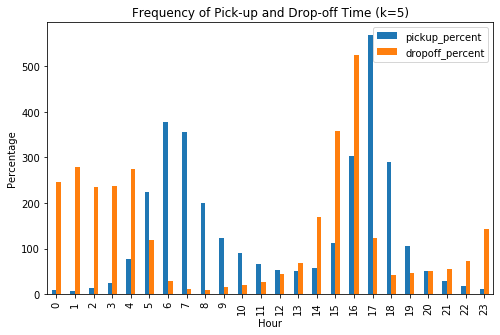

In [14]:
## Compute percentage

pickup_df = sampled_trip.loc[sampled_trip['first_pickup'] == 1]
pickup_per = pickup_df.groupby(['pickup_day', 'pickup_hour', 'pickup_weekday'])['pickup_hour'].count()
# pickup_per = pickup_per.groupby('pickup_day').apply(lambda x: x / x.sum() * 100)
pickup_per = pd.DataFrame(pickup_per).rename(columns={'pickup_hour':'pickup_percent'}).reset_index().\
                                        rename(columns={'pickup_day':'date',
                                                        'pickup_hour':'hour',
                                                           'pickup_weekday': 'weekday'})

dropoff_df = sampled_trip.loc[sampled_trip['last_dropoff'] == 1]
dropoff_per = dropoff_df.groupby(['dropoff_day', 'dropoff_hour', 'dropoff_weekday'])['dropoff_hour'].count()
# dropoff_per = dropoff_per.groupby('dropoff_day').apply(lambda x: x / x.sum() * 100)
dropoff_per = pd.DataFrame(dropoff_per).rename(columns={'dropoff_hour':'dropoff_percent'}).reset_index().\
                                        rename(columns={'dropoff_day':'date',
                                                        'dropoff_hour':'hour',
                                                           'dropoff_weekday': 'weekday'})

pick_drop_per = pickup_per.merge(dropoff_per)
pick_drop_per.head()


# % of Pick-up and Drop-off Time
pick_drop_per_all = pick_drop_per.groupby(['hour'])['pickup_percent','dropoff_percent'].mean().\
                                reset_index().set_index('hour')

fig,ax = plt.subplots(figsize = (8,5))
pick_drop_per_all.plot(kind='bar',ax=ax);
ax.set_xlabel('Hour');
ax.set_ylabel('Percentage');
ax.set_title('Frequency of Pick-up and Drop-off Time (k={})'.format(k));
ax.legend();

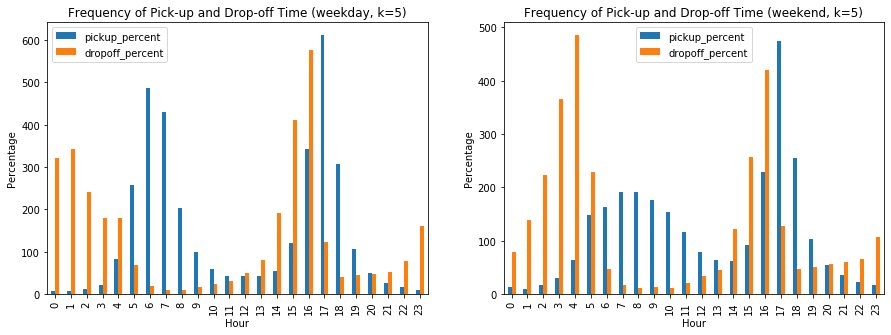

In [16]:
# Frequency of Pick-up and Drop-off Time (weekday and weekend)
pick_drop_per_wk = pick_drop_per.groupby(['hour','weekday'])['pickup_percent','dropoff_percent'].mean().\
                                reset_index().set_index('hour')

fig,ax = plt.subplots(1,2,figsize = (15,5))
pick_drop_per_wk[pick_drop_per_wk.weekday == 1].drop('weekday',axis=1).plot(kind='bar',ax=ax[0]);
pick_drop_per_wk[pick_drop_per_wk.weekday == 0].drop('weekday',axis=1).plot(kind='bar',ax=ax[1]);
ax[0].set_xlabel('Hour');
ax[0].set_ylabel('Percentage');
ax[0].set_title('Frequency of Pick-up and Drop-off Time (weekday, k={})'.format(k));
ax[0].legend();

ax[1].set_xlabel('Hour');
ax[1].set_ylabel('Percentage');
ax[1].set_title('Frequency of Pick-up and Drop-off Time (weekend, k={})'.format(k));
ax[1].legend();

# Active time
- The active time of most drivers is 8 to 10 hours

In [17]:
# compute active time 
# Active time = end time of the shift - start time of the shift
active_time = sampled_trip.loc[sampled_trip['last_dropoff'] == 1,
                               ['hack_license', 'dropoff_datetime','pickup_datetime_next']].\
                        rename(columns={'pickup_datetime_next':'start_datetime'}).\
                        sort_values(['hack_license','start_datetime'])

active_time['end_datetime'] = active_time.groupby(['hack_license'])['dropoff_datetime'].shift(-1)
active_time['active_hour'] = (active_time['end_datetime'] - active_time['start_datetime']) / pd.Timedelta(hours=1)
active_time = active_time.drop(['dropoff_datetime'], axis=1).dropna()
active_time.head()

,hack_license,start_datetime,end_datetime,active_hour
15,2013000003,2013-06-01 17:44:00,2013-06-02 05:15:00,11.516667
53,2013000003,2013-06-02 18:12:00,2013-06-03 02:55:00,8.716667
85,2013000003,2013-06-03 16:19:00,2013-06-03 23:49:00,7.500000
106,2013000003,2013-06-06 18:16:00,2013-06-07 02:54:00,8.633333
132,2013000003,2013-06-07 18:22:00,2013-06-08 04:58:00,10.600000


In [18]:
# drop incorrect record 
n = active_time[(active_time.active_hour<0) | (active_time.active_hour>=24)].shape[0] / active_time.shape[0] * 100
print('drop {n:.2f}% records'.format(n=n))
active_time = active_time[(active_time.active_hour>0) & (active_time.active_hour<24)]

drop 0.19% records


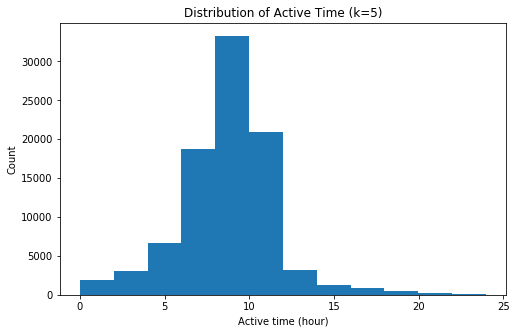

In [45]:
fig,ax = plt.subplots(figsize = (8,5))
ax.hist(active_time.loc[:,'active_hour'], bins=12);
ax.set_xlabel('Active time (hour)');
ax.set_ylabel('Count');
ax.set_title('Distribution of Active Time (k={})'.format(k));

# Trip distance
- Over 99% trips are within 20 miles; most of the trips are within 5 miles

99.59% trips are within 20 miles distance.


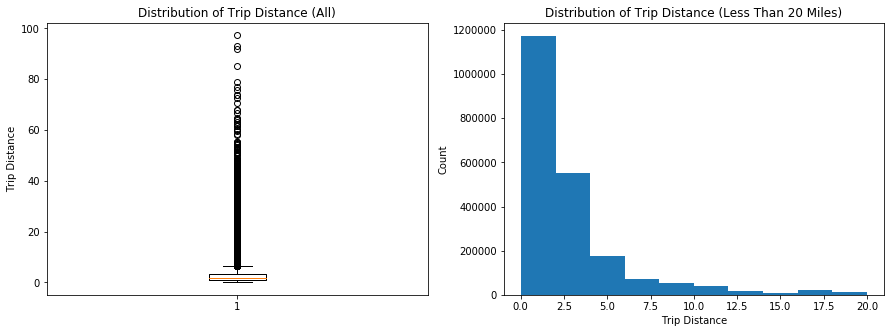

In [53]:
fig,ax = plt.subplots(1,2,figsize = (15,5))
ax[0].boxplot(sampled_trip.loc[sampled_trip['trip_distance']>0, 'trip_distance']);
ax[1].hist(sampled_trip.loc[(sampled_trip['trip_distance']>0) & (sampled_trip['trip_distance']<20), 'trip_distance']);
ax[0].set_ylabel('Trip Distance');
ax[0].set_title('Distribution of Trip Distance (All)');

ax[1].set_xlabel('Trip Distance');
ax[1].set_ylabel('Count');
ax[1].set_title('Distribution of Trip Distance (Less Than 20 Miles)');
n = len(sampled_trip.loc[(sampled_trip['trip_distance']>0) & (sampled_trip['trip_distance']<20), 'trip_distance']) / \
    len(sampled_trip.loc[sampled_trip['trip_distance']>0, 'trip_distance']) * 100
print('{:.2f}% trips are within 20 miles distance.'.format(n))

# First pick-up and last drop-off location

In [22]:
import geopandas as gpd
from shapely import wkt
from shapely.geometry import Point, Polygon

In [44]:
# download map here: https://data.cityofnewyork.us/Health/Modified-Zip-Code-Tabulation-Areas-MODZCTA-Map/5fzm-kpwv
nyc_map = pd.read_csv(path + '../Modified_Zip_Code_Tabulation_Areas__MODZCTA_.csv')
nyc_map['geometry'] = nyc_map['the_geom'].apply(wkt.loads)
nyc_map = gpd.GeoDataFrame(nyc_map, crs='EPSG:4326').drop('the_geom', axis=1)

# download map here: https://data.cityofnewyork.us/City-Government/Neighborhood-Tabulation-Areas-NTA-/cpf4-rkhq
# nyc_map = gpd.read_file(path + '../Neighborhood Tabulation Areas (NTA).geojson')

# download map here: https://data.cityofnewyork.us/Business/Zip-Code-Boundaries/i8iw-xf4u
# nyc_map = gpd.read_file(path + '../ZIP_CODE_040114/ZIP_CODE_040114.shp')

# download map here: https://data.cityofnewyork.us/City-Government/Borough-Boundaries/tqmj-j8zm
# nyc_map = gpd.read_file(path +'../Borough_Boundaries/geo_export_573e53b9-f38f-46eb-be8d-0f07d0d0e9d1.shp')
nyc_map.head()

,MODZCTA,label,ZCTA,pop_est,geometry
0,10001,"10001, 10118","10001, 10119, 10199",23072,"MULTIPOLYGON (((-73.98774 40.74407, -73.98819 ..."
1,10002,10002,10002,74993,"MULTIPOLYGON (((-73.99750 40.71407, -73.99709 ..."
2,10003,10003,10003,54682,"MULTIPOLYGON (((-73.98864 40.72293, -73.98876 ..."
3,10004,10004,10004,3028,"MULTIPOLYGON (((-74.00827 40.70772, -74.00937 ..."
4,10005,10005,"10005, 10271",8831,"MULTIPOLYGON (((-74.00783 40.70309, -74.00786 ..."


In [24]:
# drop gps records (roughly) outside of nyc 
location_index = (sampled_trip['pickup_longitude'] < -73.6) &   \
                    (sampled_trip['pickup_longitude'] > -74.3) & \
                    (sampled_trip['pickup_latitude'] > 40) & \
                    (sampled_trip['pickup_latitude'] < 41) & \
                    (sampled_trip['dropoff_longitude'] < -73.6) & \
                    (sampled_trip['dropoff_longitude'] > -74.3) & \
                    (sampled_trip['dropoff_latitude'] > 40) & \
                    (sampled_trip['dropoff_latitude'] < 41)
features = ['hack_license','trip_distance','first_pickup','last_dropoff',
            'dropoff_hour','pickup_hour','pickup_weekday','dropoff_weekday',
            'pickup_longitude','pickup_latitude',
            'dropoff_longitude','dropoff_latitude']

# convert the first pickup location to geometric form
pickup_location = sampled_trip.loc[(sampled_trip['first_pickup'] == 1) & location_index, features]
pickup_location = gpd.GeoDataFrame(pickup_location, 
                                   geometry = gpd.points_from_xy(pickup_location['pickup_longitude'],
                                                                 pickup_location['pickup_latitude']))

# convert the last dropoff location to geometric form
dropoff_location = sampled_trip.loc[(sampled_trip['last_dropoff'] == 1) & location_index, features]
dropoff_location = gpd.GeoDataFrame(dropoff_location, 
                                    geometry = gpd.points_from_xy(dropoff_location['dropoff_longitude'],
                                                                  dropoff_location['dropoff_latitude']))

pickup_location.head()

,hack_license,trip_distance,first_pickup,last_dropoff,dropoff_hour,pickup_hour,pickup_weekday,dropoff_weekday,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,geometry
16,2013000003,2.37,1.0,0,17,17,0,0,-73.972763,40.749046,-73.997505,40.724464,POINT (-73.97276 40.74905)
54,2013000003,1.33,1.0,0,18,18,0,0,-73.986984,40.729465,-74.001740,40.719578,POINT (-73.98698 40.72947)
86,2013000003,19.89,1.0,0,17,16,1,1,-73.782318,40.644684,-74.005867,40.740231,POINT (-73.78232 40.64468)
107,2013000003,2.29,1.0,0,18,18,1,1,-73.965141,40.759521,-73.947655,40.784473,POINT (-73.96514 40.75952)
133,2013000003,0.79,1.0,0,18,18,1,1,-73.966019,40.758438,-73.973877,40.751431,POINT (-73.96602 40.75844)


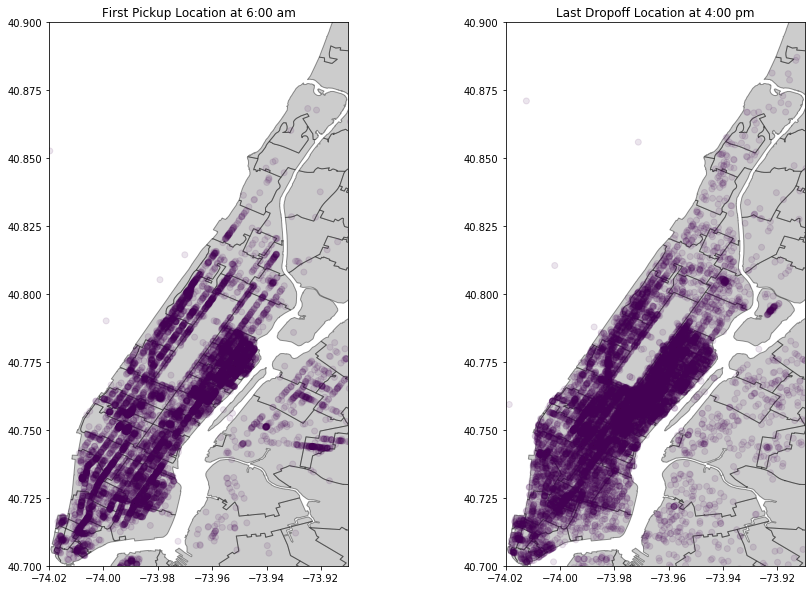

In [97]:
fig, ax = plt.subplots(1, 2, figsize=(15,10))
# add mapfile to axes
nyc_map.plot(ax=ax[0], alpha=0.4, edgecolor='k', color='grey');
pickup_location[(pickup_location['pickup_hour'] == 6)].plot(column='first_pickup', ax=ax[0], alpha=0.1);
# set latitiude and longitude boundaries for map display
ax[0].set_xlim(-74.02,-73.91);
ax[0].set_ylim( 40.7,40.9);
ax[0].set_title('First Pickup Location at 6:00 am');

# add mapfile to axes
nyc_map.plot(ax=ax[1], alpha=0.4, edgecolor='k', color='grey');
dropoff_location[(dropoff_location['dropoff_hour'] == 16)].plot(column='last_dropoff', ax=ax[1], alpha=0.1);
# set latitiude and longitude boundaries for map display
ax[1].set_xlim(-74.02,-73.91);
ax[1].set_ylim( 40.7,40.9);
ax[1].set_title('Last Dropoff Location at 4:00 pm');

# Location of long-distance trip

In [90]:
long_lon = pd.melt((sampled_trip.loc[sampled_trip['trip_distance']>60,
                                     ['trip_distance','pickup_longitude','dropoff_longitude']]).
                   rename(columns={'pickup_longitude': 'pickup',
                                   'dropoff_longitude': 'dropoff'}),
                   id_vars = 'trip_distance').rename(columns={'value':'longitude'})
long_lat = pd.melt((sampled_trip.loc[sampled_trip['trip_distance']>60,
                                     ['trip_distance','pickup_latitude','dropoff_latitude']]).
                   rename(columns={'pickup_latitude': 'pickup',
                                   'dropoff_latitude': 'dropoff'}),
                   id_vars = 'trip_distance').rename(columns={'value':'latitude'})

long_trip_location = long_lon.merge(long_lat)
long_trip_location = gpd.GeoDataFrame(long_trip_location, 
                                      geometry = gpd.points_from_xy(long_trip_location['longitude'],
                                                                    long_trip_location['latitude']))
# long_trip_location.loc[:, 'variable'] = [0 if v == 'pickup' else 1 for v in long_trip_location.variable]
long_trip_location.head()

,trip_distance,variable,longitude,latitude,geometry
0,73.97,pickup,-73.876175,40.771648,POINT (-73.87618 40.77165)
1,64.23,pickup,-73.791725,40.656113,POINT (-73.79172 40.65611)
2,61.80,pickup,-73.981834,40.758343,POINT (-73.98183 40.75834)
3,70.72,pickup,-73.807358,40.656273,POINT (-73.80736 40.65627)
4,62.29,pickup,-73.874237,40.773773,POINT (-73.87424 40.77377)


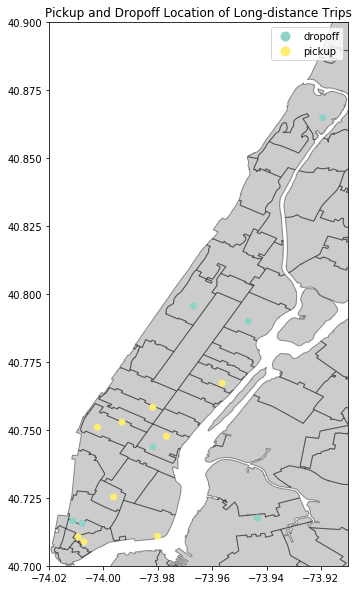

In [107]:
fig, ax = plt.subplots(figsize=(15,10))
# add mapfile to axes
nyc_map.plot(ax=ax, alpha=0.4, edgecolor='k', color='grey');
long_trip_location.plot(column='variable', ax=ax, legend=True, cmap='Set3');
# set latitiude and longitude boundaries for map display
ax.set_xlim(-74.02,-73.91);
ax.set_ylim( 40.7,40.9);
ax.set_title('Pickup and Dropoff Location of Long-distance Trips');